In [1]:
import pandas as pd
import numpy as np

%pylab inline
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.naive_bayes import MultinomialNB as MNB, GaussianNB as GNB, BernoulliNB as BNB
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import joi
from sklearn.base import BaseEstimator
from sklearn.grid_search import GridSearchCV

//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import operator

from nltk import collocations
import nltk 

from collections import defaultdict
from gensim.models import word2vec

import xgboost as xgb

### 1. Загрузка данных

#### 1.1. Сырые данные

In [4]:
data = pd.read_csv('ram_train.csv')

In [5]:
data.head(5)

uid  time                                              title  age  sex
0  112942     0  Рамблер/почта – надежная и бесплатная электрон...    5    0
1  111499     0  Россия ответила на претензии США по размещению...    3    1
2  237186     0  Вести.Ru: Останки убитой девочки родители разб...    3    0
3  265356     1  Работа, вакансии, база резюме, поиск работы на...    3    1
4  240286     1  Севилья – Барселона 14 августа 2016, воскресен...    3    1

#### 1.2. Предобработанные данные. Проведена токенезация, нормализация(леммитизация), удалены стоп слова

In [6]:
def load_batches(n):
    df_batches = pd.DataFrame()
    for i in range(n):
        data = pd.read_csv("batch/batch_{0}.csv".format(i), index_col=0)
        df_batches = pd.concat([df_batches, data], ignore_index=True)
    return df_batches

In [7]:
data_norm = load_batches(287)

In [8]:
users =  data[['uid', 'age', 'sex']].groupby('uid').mean()
users = np.round(users)

In [9]:
ndata = data_norm.join(users, on = ['uid'], how = 'left')

#### 1.3. Объединяем пользователей. Учитываем истоию пользователей в совокупности

In [10]:
if ndata.isnull().values.sum() > 0:
    print("Number of null values: {0}".format(ndata.isnull().values.sum()))
    df = ndata.dropna()

Number of null values: 4741


In [11]:
def join_user_with_same_uid(users):
    return pd.Series(data=(users.uid.values[0], ". ".join(users.title), users.sex.values[0], users.age.values[0]), index=['uid', 'title', 'sex', 'age'])

In [12]:
udata = df.groupby('uid').apply(join_user_with_same_uid)

In [13]:
print("Количество пользователей: {0}".format(udata.shape[0]))

Количество пользователей: 299996


### 2. Анализ данных

#### 2.1. Пол

In [14]:
udata.sex.value_counts()

1.0    183015
0.0    116981
Name: sex, dtype: int64

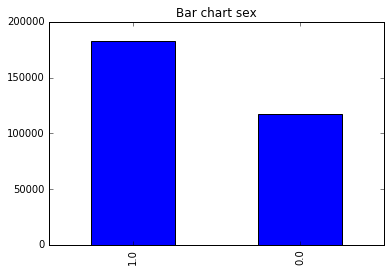

In [15]:
udata.sex.value_counts().plot(kind='bar', title="Bar chart sex")

#### 2.2. Возраст

In [16]:
udata.age.value_counts()

3.0    94170
4.0    82116
5.0    55011
6.0    27900
2.0    24276
7.0    10334
1.0     6189
Name: age, dtype: int64

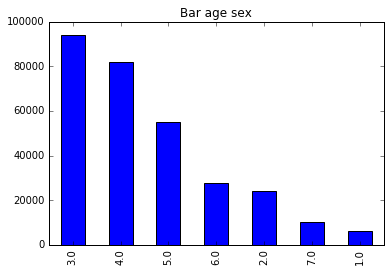

In [17]:
udata.age.value_counts().plot(kind='bar', title="Bar age sex")

#### 2.3. Текст

#### 2.3.1 Так как стартовые страницы для каждого из пользователей, внезависмости от пола и возраста могут быть одинаковыми - необходимо их выкинуть так как они не влияют на определение пола и возраста,  а лишь зашумляют данные. 

In [14]:
df.title.value_counts()[0:5000]

рамблер медийный портал                                                                                                                                 4937039
рамблер почта надёжный бесплатный электронный почта                                                                                                     4233091
рамблер                                                                                                                                                  397819
lenta ru                                                                                                                                                 214633
чемпионат com новость спорт чемпионат                                                                                                                    188589
рамблер новость                                                                                                                                          187114
главный рамблер новость                 

#### Рассмотрим 1-ые 10-ть часто посещаемых сайтов.

In [14]:
most_freq_title_list = df.title.value_counts()[0:10]

In [15]:
for title in most_freq_title_list.keys():
    print("Заголвок:{0}".format(title))
    print(df[df.title == title]['sex'].value_counts())
    print(df[df.title == title]['age'].value_counts())

Заголвок:рамблер медийный портал
1.0    3416762
0.0    1520277
Name: sex, dtype: int64
4.0    1466486
5.0    1190556
3.0    1085315
6.0     683245
7.0     265401
2.0     171231
1.0      74805
Name: age, dtype: int64
Заголвок:рамблер почта надёжный бесплатный электронный почта
1.0    2542392
0.0    1690699
Name: sex, dtype: int64
4.0    1196323
3.0    1167684
5.0     885552
6.0     465793
2.0     258872
7.0     177973
1.0      80894
Name: age, dtype: int64
Заголвок:рамблер
1.0    294283
0.0    103536
Name: sex, dtype: int64
5.0    122469
4.0    113398
6.0     74024
3.0     48555
7.0     26023
1.0      6712
2.0      6638
Name: age, dtype: int64
Заголвок:lenta ru
1.0    179502
0.0     35131
Name: sex, dtype: int64
3.0    73991
4.0    62619
5.0    36992
6.0    17450
2.0    11199
7.0     8907
1.0     3475
Name: age, dtype: int64
Заголвок:чемпионат com новость спорт чемпионат
1.0    167991
0.0     20598
Name: sex, dtype: int64
3.0    76436
4.0    42409
5.0    25283
2.0    21031
6.0    14914


#### Гипотеза подтвердилась. Удалим ненужные  данные из выборки.

In [16]:
clear_most_freq_title_list = df.title.value_counts()[0:5000]

In [17]:
clear_most_freq_title_list.tail(10)

беляков завоевать россия бронза бокс вес килограмм рамблер новость                                 355
блог футбол динамо киев шурик                                                                      355
почему renault duster хороший пoкупать                                                             355
коллекция караван история день ру                                                                  355
одноразовый мир компания стать намеренно выпускать неремонтопригодный техника военный обозрение    355
coral travel ukraine                                                                               355
тасс политика ольга васильев известно новый министр образование                                    355
адрес офис exist ru россия                                                                         354
украина воевать                                                                                    354
жилищный кодекс российский федерация n фз ред консультантплюс            

In [18]:
clear_df = df[~df['title'].isin(clear_most_freq_title_list.head(5000).index)]

In [19]:
print("Объем данных сократился в {0:2f}".format(df.shape[0] / clear_df.shape[0]))

Объем данных сократился в 2.826289


In [20]:
cdata = clear_df.groupby('uid').apply(join_user_with_same_uid)

In [21]:
print("Количество пользователей: {0}".format(cdata.shape[0]))

Количество пользователей: 281954


#### 2.3.2 Для такого чтобы с текстом проводить какие-нибудь операции, необходимо векторизовать текст. Применим подход TF-IDF. И найдем какие слова встречаются чаще всего в тексте

In [22]:
X = cdata.title
vectorizer = TfidfVectorizer().fit(X)
tf_idf_train = vectorizer.transform(X)

In [23]:
tf_idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [24]:
dict_freq_words = sorted(tf_idf_dict.items(), key=operator.itemgetter(1))
freq_words = list(map(lambda x: x[0], dict_freq_words))[0:100]
dict_freq_words

[('ru', 1.5189687302457542),
 ('новость', 1.7863712612847724),
 ('рамблер', 1.8369644343207701),
 ('россия', 1.9739499767911235),
 ('москва', 2.2121695472045646),
 ('год', 2.224595047087413),
 ('весь', 2.3167013375559184),
 ('фото', 2.3233531143076425),
 ('российский', 2.374570690741729),
 ('видео', 2.486527350796286),
 ('купить', 2.4988508809324022),
 ('онлайн', 2.5373865862390792),
 ('цена', 2.5656687303214603),
 ('день', 2.6077192575226227),
 ('интернет', 2.608640230985757),
 ('новый', 2.6312012839499612),
 ('олимпиада', 2.6339416829318063),
 ('поиск', 2.6476837679723131),
 ('сайт', 2.6614118381264351),
 ('самый', 2.6826500709225938),
 ('магазин', 2.692987616592549),
 ('ру', 2.722232612550227),
 ('rambler', 2.7242594388774641),
 ('свой', 2.7258320635931783),
 ('почта', 2.7329496736642169),
 ('газета', 2.7384423689282453),
 ('мир', 2.7422830075559181),
 ('рио', 2.7530340477441464),
 ('украина', 2.7710257543324772),
 ('игра', 2.8065407299271588),
 ('спорт', 2.8227173451576872),
 ('хор

#### Наш метод никак не учитывает порядок слов в документе, а лишь подсчитывает, сколько раз каждое слово встретилось в тексте. Самый простой подход это использования N-граммы, для  учитывания порядока слов.

#### 2.4. Двуграммы N=2

In [21]:
subject_words = udata[0:1000].title.sum().split()

In [22]:
bigram_measures = collocations.BigramAssocMeasures()
bigram_finder = collocations.BigramCollocationFinder.from_words(subject_words)

In [23]:
bigram_finder.apply_freq_filter(20)
for bigram in bigram_finder.score_ngrams(bigram_measures.raw_freq):
    print(bigram)

(('медийный', 'портал.'), 0.022341090688415458)
(('рамблер', 'медийный'), 0.02206064896972149)
(('бесплатный', 'электронный'), 0.018794192557720423)
(('надёжный', 'бесплатный'), 0.018794192557720423)
(('почта', 'надёжный'), 0.018794192557720423)
(('электронный', 'почта.'), 0.018479270299842768)
(('рамблер', 'почта'), 0.018470075489393785)
(('портал.', 'рамблер'), 0.01573232067820922)
(('почта.', 'рамблер'), 0.015242697021800896)
(('рамблер', 'новость.'), 0.011157902479840378)
(('ru', 'рамблер'), 0.006252471105308164)
(('rambler', 'ru'), 0.006208795755675497)
(('рамблер', 'почта.'), 0.006178912621716303)
(('почта.', 'входящая'), 0.005523782377226293)
(('рамблер', 'поиск.'), 0.005500795351103837)
(('eleba', 'rambler'), 0.004581314306205578)
(('входящая', 'eleba'), 0.004581314306205578)
(('новость.', 'рамблер'), 0.003420469487021525)
(('lenta', 'ru.'), 0.0031400277683275558)
(('интернет', 'магазин'), 0.003036586150776502)
(('олимпиада', 'рио'), 0.0025216767656334764)
(('онлайн', 'трансляц

#### 2.5. Трехграммы N=3

In [24]:
trigram_measures = collocations.TrigramAssocMeasures()
trigram_finder = collocations.TrigramCollocationFinder.from_words(subject_words)

In [25]:
trigram_finder.apply_freq_filter(20)
for trigram in trigram_finder.score_ngrams(trigram_measures.raw_freq):
    print(trigram)

(('рамблер', 'медийный', 'портал.'), 0.021948012541721452)
(('надёжный', 'бесплатный', 'электронный'), 0.018794192557720423)
(('почта', 'надёжный', 'бесплатный'), 0.018794192557720423)
(('бесплатный', 'электронный', 'почта.'), 0.018476971597230524)
(('рамблер', 'почта', 'надёжный'), 0.01846317938155705)
(('медийный', 'портал.', 'рамблер'), 0.015727723272984728)
(('электронный', 'почта.', 'рамблер'), 0.014879502009066082)
(('почта.', 'рамблер', 'почта'), 0.013224436128249216)
(('портал.', 'рамблер', 'медийный'), 0.012898020357310334)
(('rambler', 'ru', 'рамблер'), 0.006204198350451005)
(('ru', 'рамблер', 'почта.'), 0.006176613919104058)
(('рамблер', 'почта.', 'входящая'), 0.005070937962613901)
(('eleba', 'rambler', 'ru'), 0.004581314306205578)
(('входящая', 'eleba', 'rambler'), 0.004581314306205578)
(('почта.', 'входящая', 'eleba'), 0.004579015603593332)
(('рамблер', 'новость.', 'рамблер'), 0.003335417490368436)
(('новость.', 'рамблер', 'медийный'), 0.0027124690824498654)
(('портал.', '

#### Выводы: 1. При нахождении частности слов, высокочастное/низкочастотное встречаемость слов может влиять на качество модели, заголовок со словом "Почта" его могут просматривать мужчина так и женщины, поэтому их нужно убрать при обучении. 2.Как видно из N-грамм слова в тексте связанны и их нужно учитывать в признаках при построении модели.

### 3. Построение моделей

#### 3.1. Перемещаем данные

In [25]:
rusers = cdata
shuff_users = rusers.set_index(rusers.uid)
arr_index = rusers.index.values
np.random.shuffle(arr_index)
shuffle_data = shuff_users.ix[arr_index]
cdata = cdata.set_index(cdata.uid)

#### Посчитаем кол-во признаков после векторизации.

In [ ]:
print("Количество признаков после векторизации: {0}".format(tf_idf_train.shape[1]))

#### Кол-во признаков получилось слишком большим - 440433 (10^3 – 10^4), если добавить биграммы и триграммы, то при использовании большого корпуса текстов количество признаков может достигать 10^6 – 10^7. Рассмотрим несколько вариантов построение моделей в данном случае: 1. Использование линейных методов 2. Понижение размерности (Метод главных компонент) и обучение с помощью бустинга. 3. Использование Word2Vec для векторизации признаков и обучение с помощью бустинга. Рассмотрим все эти варианты.

#### 3.2. Определение пола

#### 3.2.1 Линейные методы. 

In [44]:
sdata = shuffle_data.head(int(shuffle_data.shape[0]/10))

In [45]:
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(sdata.title, sdata.sex, test_size=0.33)###!!!стратифицировать выборку!!!

#### Выбор линейного классификатора

In [101]:
for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
    pipeline_tfid_liner = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', clf())
    ])
    print(clf)
    print(cross_val_score(pipeline_tfid_liner, X_sex_train, y_sex_train, scoring="roc_auc", cv=3).mean())

<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.774493814921
<class 'sklearn.svm.classes.LinearSVC'>
0.763923251858
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0.769607794137


#### Подбор гиперпараметров

In [119]:
pipeline_tfid_log = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', LogisticRegression())
    ])

parameters = {
    'clf__C': (0.01, 1, 10),
    'clf__penalty': ('l1', 'l2')
}

In [120]:
grid_pipeline_tfidf_svc = GridSearchCV(pipeline_tfid_log, parameters, scoring="roc_auc", cv=3)
grid_pipeline_tfidf_svc.fit(X_sex_train, y_sex_train)
print(grid_pipeline_tfidf_svc.best_params_)
print(grid_pipeline_tfidf_svc.best_score_)

{'clf__C': 1, 'clf__penalty': 'l2'}
0.7753667507339925


#### Лучший результат линейной модели

In [64]:
sdata = shuffle_data.head(int(shuffle_data.shape[0]))

In [65]:
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(sdata.title, sdata.sex, test_size=0.33)

In [125]:
pipeline_tfid_log = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('clf', LogisticRegression(C=1, penalty='l2'))
    ])

In [126]:
print(cross_val_score(pipeline_tfid_log, X_sex_train, y_sex_train, scoring="roc_auc", cv=3).mean())

0.799850660689


In [127]:
pipeline_tfid_log.fit(X_sex_train, y_sex_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [128]:
y_pred = pipeline_tfid_log.predict_proba(X_sex_test)
roc_auc_score(y_sex_test, y_pred[:,1])

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


0.805172205320138

#### Вывод: Логистическая регрессия дает самое лучшее качество roc_auc = 0.805172205320138; среди всех линейных моделей

#### Сохраним нашу модель 

In [ ]:
from sklearn.externals import joblib
filename = '/Volumes/TOSHIBA/Diplom/pipeline_tfid_log_model.sav'
pickle.dump(pipeline_tfid_log, open(filename, 'wb'))

#### 3.2.2 Понижение размерности, построение случайного леса и градиентаного бустинга.

In [ ]:
pipeline_tfidf_svd_tree = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),###min_df=2, max_df=0.01, без stowords: 0.73279538452835213
        ('svd', TruncatedSVD(n_components=100)),
        ('clf', ExtraTreesClassifier(n_estimators=100))
    ])

In [ ]:
cross_val_score(pipeline_tfidf_svd_tree, X_sex_train, y_sex_train, scoring="roc_auc", cv=3).mean()

#### 3.2.3 Word2Vec, построение случайного леса и градиентаного бустинга.

#### 3.2.3.1 Подготовка данных

In [67]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def word2vec_format(X):
    sentences = []
    for i in X.iteritems():
        for token in tokenizer.tokenize(i[1]):
            sentences.append(token)
    return sentences

In [81]:
X_sex_train

uid
340718.0    болт выйти финал олимпиада бег метр гэтлина че...
113677.0    российский тренер грёкий римский борьба слово ...
287396.0    откуда хотеть заказать цветочный форум. ожидан...
199338.0    неизвестный открыть стрельба кёлен рамблер нов...
304984.0    медведица растерзать летний девочка телеканал ...
94624.0     отец жанна фриска подать суд журналист рамблер...
320951.0    кинотеатр морить синемой мытищи расписание рец...
310775.0    розетка японский стандарт рамблер поиск. розет...
79044.0     интернет магазин мужской одежда цум. интернет ...
275506.0    барокамера лечение показание противопоказание ...
198141.0    аппарат голодец ответить сообщение замена инде...
238444.0    newsru com тверь летний девочка побои кипяток ...
251714.0    федеральный закон n фз ред страхов пенсия конс...
58404.0     олимпийский рио обходиться день происшествие. ...
6489.0      продать дача омский область омский садовод. ки...
300766.0                                                    1
1594

In [76]:
trainSexDataVecs = word2vec_format(X_sex_train)

TypeError: expected string or bytes-like object

In [137]:
modelSex = word2vec.Word2Vec(trainSexDataVecs, size=100, window=5, min_count=5, workers=2)

In [138]:
w2vSex = {w: vec for w, vec in zip(modelSex.wv.index2word, modelSex.wv.syn0)}

In [ ]:
modelSex.save("word2vec_feauters_sex")

#### 3.2.3.2 Создание W2V векторизатор

In [ ]:
class MeanEmbeddingVectorizer(BaseEstimator):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = list(word2vec.values())[0].shape[0]

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
class TfidfEmbeddingVectorizer(BaseEstimator):
    def __init__(self, word2vec, freq_words=None):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = list(word2vec.values())[0].shape[0]
        self.freq_words = freq_words

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x, stop_words=self.freq_words, ngram_range=(1, 3))
        tfidf.fit(X)
        
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

#### 3.2.3.3 Обучение Word2Vec

In [ ]:
pipeline_sex_word2vec_tree = Pipeline([
    ("vec", TfidfEmbeddingVectorizer(w2vSex, freq_words)),
    ("clf", ExtraTreesClassifier(n_estimators=100))])

In [ ]:
cross_val_score(pipeline_sex_word2vec_tree, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

#### 3.2.4 XGBoost

In [99]:
pipeline_sex_meanvect_xgboost = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('svd', TruncatedSVD(n_components=100)),
    ("clf", xgb.XGBClassifier())])

In [100]:
cross_val_score(pipeline_sex_meanvect_xgboost, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.75800995702754681

#### 3.5. Использование композицию алгоритмов, для улучшения качества

#### 3.6 RusVecotres

In [144]:
model = word2vec.KeyedVectors.load_word2vec_format("/Users/anton/Documents/news_0_300_2.bin", binary=True)

In [156]:
m2vRusVectores = {w: vec for w, vec in zip(list(map(lambda x: x.split("_")[0], model.index2word)), model.syn0)}

In [159]:
pipeline_w2v_tfidf_rusvect = Pipeline([
    ("vec", TfidfEmbeddingVectorizer(m2vRusVectores)),
    ("clf", ExtraTreesClassifier(n_estimators=100))])

In [160]:
cross_val_score(pipeline_w2v_tfidf_rusvect, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.64499396149427957

In [161]:
model = word2vec.KeyedVectors.load("/Users/anton/ML/ml_course/Rambler/word2vec_feauters_sex")
m2vRusVectores = {w: vec for w, vec in zip(list(map(lambda x: x.split("_")[0], model.index2word)), model.syn0)}
pipeline_w2v_tfidf_rusvect = Pipeline([
    ("vec", TfidfEmbeddingVectorizer(m2vRusVectores)),
    ("clf", ExtraTreesClassifier(n_estimators=100))])

In [165]:
cross_val_score(pipeline_w2v_tfidf_rusvect, X_sex_train, y_sex_train, scoring='roc_auc', cv=3).mean()

0.60009230820257986

#### 3.3 Определение возраста

#### Возраст разбит на 7 интервалов возрастов. Отчет ведется от наименьшего из интервалов(1) до наибольшего (7).

#### Построим многоклассовую классификацию с использованием линейных моделей. 

In [26]:
adata = shuffle_data.head(int(shuffle_data.shape[0]/10))

In [27]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(adata.title, adata.age, test_size=0.33)###!!!стратифицировать выборку!!!

In [28]:
pipeline_age_tfidf_linear_reg = Pipeline([
        ('vect', TfidfVectorizer(stop_words=freq_words, ngram_range=(1, 3))),
        ('svd', TruncatedSVD(n_components=100)),
        ('clf', )
    ])

In [30]:
cross_val_score(pipeline_age_tfidf_linear_reg, X_age_train, y_age_train, scoring="roc_auc", cv=3).mean()

ValueError: multiclass format is not supported

#### Из предыдущего примера, видим что наше качество не отличается от наугад выбранного возраста. Объединеним возраст по группам — (1, 2), (3, 4) и (5, 6, 7).

In [29]:
def changeAgeGroup(sdata):
    sdata.loc[((sdata.age == 1) | (sdata.age == 2)), 'age'] = 1
    sdata.loc[((sdata.age == 3) | (sdata.age == 4)), 'age'] = 2
    sdata.loc[((sdata.age == 5) | (sdata.age == 6) | (sdata.age == 7)), 'age'] = 3
    return sdata

In [36]:
age_data = changeAgeGroup(shuffle_data.copy())

In [37]:
age_data.age.value_counts()

2.0    165344
3.0     87812
1.0     28697
Name: age, dtype: int64

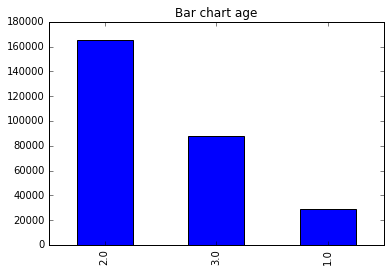

In [39]:
age_data.age.value_counts().plot(kind='bar', title="Bar chart age")

In [ ]:
"".format(age_data.age.value_counts().min() / age_data.age.value_counts().max())

#### Построим линейный классфикатор. 